In [1]:
%pylab inline
%matplotlib inline

# Global Imports
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
from sklearn import datasets
import os
import sys
import pickle
from pprint import pprint
from time import time
import datetime
from time import gmtime, strftime
import statsmodels.api as sm
from patsy import dmatrices

# Scikit-Learn imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import cross_val_score
from sklearn import metrics

# Local Imports
path = str(os.path.expanduser('~')) + '/git/predictEPL/config'
sys.path.append(path)
import paths

sys.path.append(paths.UTILS)
import useful_methods

Populating the interactive namespace from numpy and matplotlib


# 0. Data

In [2]:
def ReadEmolexDf():
    # Read game_infos as df
    dfGameInfo = useful_methods.csv_dic_df(paths.READ_PATH_GAME_INFO + 'game_infos.csv')
    dfGameInfo = useful_methods.DropNanGames(dfGameInfo).copy().reset_index(drop=True)
    dfGameInfo.GW = [int(gw) for gw in dfGameInfo.GW]
    dfGameInfo = dfGameInfo.sort_values(['GW', 'away_team'], ascending=[True, True]).copy().reset_index(drop=True)

    # Read Hash Emolex Model result
    df = useful_methods.csv_dic_df(paths.READ_PATH_RESULTS + RESULT_FILE_NAME)
    df.GW = [int(gw) for gw in df.GW]
    df = df.sort_values(['GW', 'away_team'], ascending=[True, True]).copy().reset_index(drop=True)

    df.emolex_home = [np.array([float(emo.strip()) for emo in emolex_home[1:-2].split('.')]) for emolex_home in list(df.emolex_home)]
    df.emolex_away = [np.array([float(emo.strip()) for emo in emolex_away[1:-2].split('.')]) for emolex_away in list(df.emolex_away)]


    # Combine 2 dfs
    df['score_ht_away'] = [int(item) for item in dfGameInfo.score_ht_away]
    df['score_ht_home'] = [int(item) for item in dfGameInfo.score_ht_home]
    df['score_ft_away'] = [int(item) for item in dfGameInfo.score_ft_away]
    df['score_ft_home'] = [int(item) for item in dfGameInfo.score_ft_home]

    # 'home_win': 1, 'away_win': 0, 'draw': 2
    def Labeling(goal_diff):
        if goal_diff > 0:
            return 1
        elif goal_diff < 0:
            return 0
        else:
            return 2

    df['goal_diff_ht'] = df.score_ht_home - df.score_ht_away
    df['goal_diff_ft'] = df.score_ft_home - df.score_ft_away
    df['result'] = [Labeling(item) for item in df.goal_diff_ft]


    # **********************************************
    # Add previous 4 games points sum
    dfBe4GameSum = useful_methods.csv_dic_df(paths.DATA_HOME + "EPL/info_before_4game_sum.csv")

    team_homes = list(df.home_team)
    team_aways = list(df.away_team)
    GWs = [int(gw) for gw in df.GW]

    be_4game_sum_home = []
    be_4game_sum_away = []

    for index in range(len(GWs)):
        team_home = team_homes[index]
        team_away = team_aways[index]
        gw = GWs[index]

        be_4game_sum_home.append(int(dfBe4GameSum[dfBe4GameSum.team == team_home][str(gw)]))
        be_4game_sum_away.append(int(dfBe4GameSum[dfBe4GameSum.team == team_away][str(gw)]))

    df['be_4game_sum_away'] = be_4game_sum_away
    df['be_4game_sum_home'] = be_4game_sum_home    

    return df

In [3]:
# Create df for models.
def CreateDfForModel(ht_draw=False, ft_wld=False):
    df = ReadEmolexDf()
        
    # only for Win or Lose
    if not ft_wld:
        df = df[df.result != 2].copy().reset_index(drop=True)
    
    # HT: Equal
    if ht_draw:
        df = df[df.goal_diff_ht == 0].copy().reset_index(drop=True)
    
    dta = pd.DataFrame()
    
    # Teams
    dta['team_home'] = df.home_team
    dta['team_away'] = df.away_team
    
    # HF scores
    dta['score_ht_home'] = df.score_ht_home
    dta['score_ht_away'] = df.score_ht_away
    
    dta['goal_diff_ht'] = df['goal_diff_ht']
    dta['goal_diff_ft'] = df['goal_diff_ft']

    # 'home_win': 1, 'away_win': 0, 'draw': 2
    dta['result'] = df.result
    
    # be_4game_sum
    dta['be_4game_sum_home'] = df.be_4game_sum_home / 12.0
    dta['be_4game_sum_away'] = df.be_4game_sum_away / 12.0
    
    # Emolex 8
    dta['anger_home'] = [emolex[0] / sum(emolex[:-2]) for emolex in df.emolex_home]
    dta['fear_home'] = [emolex[1] / sum(emolex[:-2]) for emolex in df.emolex_home]
    dta['disgust_home'] = [emolex[2] / sum(emolex[:-2]) for emolex in df.emolex_home]
    dta['sadness_home'] = [emolex[3] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['surprise_home'] = [emolex[4] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['trust_home'] = [emolex[5] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['joy_home'] = [emolex[6] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['anticipation_home'] = [emolex[7] / sum(emolex[:-2])  for emolex in df.emolex_home]
    dta['pos_home'] = [emolex[8] / sum(emolex[-2:])  for emolex in df.emolex_home]
    dta['neg_home'] = [emolex[9] / sum(emolex[-2:])  for emolex in df.emolex_home]

    dta['anger_away'] = [emolex[0] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['fear_away'] = [emolex[1] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['disgust_away'] = [emolex[2] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['sadness_away'] = [emolex[3] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['surprise_away'] = [emolex[4] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['trust_away'] = [emolex[5] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['joy_away'] = [emolex[6] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['anticipation_away'] = [emolex[7] / sum(emolex[:-2])  for emolex in df.emolex_away]
    dta['pos_away'] = [emolex[8] / sum(emolex[-2:])  for emolex in df.emolex_away]
    dta['neg_away'] = [emolex[9] / sum(emolex[-2:])  for emolex in df.emolex_away]
    
    
    # Diffs
    dta['diff_anger'] = dta['anger_home'] - dta['anger_away']
    dta['diff_fear'] = dta['fear_home'] - dta['fear_away']
    dta['diff_disgust'] = dta['disgust_home'] - dta['disgust_away']
    dta['diff_sadness'] = dta['sadness_home'] - dta['sadness_away']
    dta['diff_surprise'] = dta['surprise_home'] - dta['surprise_away']
    dta['diff_trust'] = dta['trust_home'] - dta['trust_away']
    dta['diff_joy'] = dta['joy_home'] - dta['joy_away']
    dta['diff_anticipation'] = dta['anticipation_home'] - dta['anticipation_away']
    dta['diff_pos'] = dta['pos_home'] - dta['pos_away']
    dta['diff_neg'] = dta['neg_home'] - dta['neg_away']
    
    
    return dta

### ODDS data

In [4]:
def ReadOddsDf():
    # Read Scores
    dfOdds = useful_methods.OddsPortalDf()

    df = dfOdds.copy()
    drop_index = []

    # drop Nan Games
    for ith_row in range(len(df)):
        # Team names
        week = df.iloc[ith_row]['GW']
        team_home = df.iloc[ith_row]['team_home']
        team_away = df.iloc[ith_row]['team_away']

        isFile = os.path.isfile(
        "/Users/Bya/Dropbox/Research/datas/EPL/ExtractedCsvData/" + "GW" + str(int(week)) + "/SingleGames/" + \
        team_home + "_vs_" + team_away + ".csv")

        if not isFile:
            drop_index.append(ith_row)

    df = df.drop(df.index[drop_index]).copy().reset_index(drop=True)


    # str to int
    str_to_num_cols = ["score_ft_home", "score_ft_away", "odds_home", "odds_away", "odds_draw"]

    for col in str_to_num_cols:
        df[col] = [np.float(item) for item in df[col]]
    
    return df

In [5]:
def CreateDfForModelOdds(ft_wld=True):
    df = CreateDfForModel(ft_wld=ft_wld)
    dfOdds = ReadOddsDf()

    odds_homes = []
    odds_aways = []
    odds_draws = []

    for ith_row in range(len(df)):
        team_home = df.loc[ith_row]['team_home']
        team_away = df.loc[ith_row]['team_away']

        odds_home = dfOdds[(dfOdds.team_home == team_home) & (dfOdds.team_away == team_away)]['odds_home']
        odds_away = dfOdds[(dfOdds.team_home == team_home) & (dfOdds.team_away == team_away)]['odds_away']
        odds_draw = dfOdds[(dfOdds.team_home == team_home) & (dfOdds.team_away == team_away)]['odds_draw']

        odds_homes.append(np.float(odds_home))
        odds_aways.append(np.float(odds_away))
        odds_draws.append(np.float(odds_draw))

    df['odds_home'] = odds_homes
    df['odds_away'] = odds_aways
    df['odds_draw'] = odds_draws
    
    return df

# 1. Learning Plot

In [6]:
from matplotlib.font_manager import FontProperties
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
_
    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    # japanese font set
    fp_normal = FontProperties(fname=r'/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', size=14)
    fp_small = FontProperties(fname=r'/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', size=10)

    # plot size
    plt.figure(figsize=(8, 5))
    
    # plot label names
    # plt.title(title)
    plt.xlabel("データ数", fontproperties=fp_small)
    plt.ylabel("精度", fontproperties=fp_small)
    
    if ylim is not None:
        plt.ylim(*ylim)
        plt.yticks(np.arange(ylim[0], ylim[1], 0.1))
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # line names, colors, types
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label=u'学習スコア')
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label=u'交差検証スコア')

    plt.legend(prop=fp_normal, loc="lower right")
    return plt

# 2. Model Functions

In [7]:
# Calculate Accuracy
# Log & SVM, cv = 18
def ModelAccuracy(X, y, penalty='l2', log_variables=False):
    # Set Models
    model_log = LogisticRegression(penalty=penalty)
    model_svc = SVC()

    # Fit to models
    model_log = model_log.fit(X, y)
    model_svc = model_svc.fit(X, y)

    # Cross Validation
    scores_log = cross_val_score(model_log, X, y, scoring='accuracy', cv=18)
    scores_svc = cross_val_score(model_svc, X, y, scoring='accuracy', cv=18)

    # Accuracy scores
    print("--------------------------\n")
    print("[Log]: \t%.3f (cv: %.3f)" % (model_log.score(X, y), scores_log.mean()))
    print("[SVC]: \t%.3f (cv: %.3f)" % (model_svc.score(X, y), scores_svc.mean()))


    # Variable Scores
    if log_variables:
        dfVars = pd.DataFrame()
        dfVars['var'] = X.columns
        dfVars['score'] = np.transpose(model_log.coef_)
        print("\n", dfVars)
    
    return model_log, model_svc

# 3. Accuracy

### Score HT

In [8]:
# File Name
RESULT_FILE_NAME = "emolex_all_ht.csv"

# Load data as DF
df = CreateDfForModel(ft_wld=False)

# Create X, y for model
y, X = dmatrices('result ~ \
            score_ht_home + score_ht_away + goal_diff_ht',
            df, return_type="dataframe")
y = np.ravel(y)

# Model Training and Results
model_log, model_svc = ModelAccuracy(X, y, penalty='l1', log_variables=False)

--------------------------

[Log]: 	0.766 (cv: 0.728)
[SVC]: 	0.766 (cv: 0.765)


## Emolex => Pos, Neg

### WIN LOSE

--------------------------

[Log]: 	0.750 (cv: 0.750)
[SVC]: 	0.594 (cv: 0.594)

                   var     score
0           Intercept  0.000000
1          anger_home  0.000000
2           fear_home  0.000000
3        disgust_home  0.000000
4        sadness_home  0.000000
5       surprise_home  0.000000
6          trust_home  0.000000
7            joy_home  0.000000
8   anticipation_home  0.000000
9          anger_away  0.000000
10          fear_away  0.000000
11       disgust_away  0.000000
12       sadness_away  0.000000
13      surprise_away  0.000000
14         trust_away  0.000000
15           joy_away  0.000000
16  anticipation_away  0.000000
17           pos_home  0.405288
18           neg_home  0.000000
19           pos_away  0.000000
20           neg_away  0.000000
21         diff_anger  0.000000
22          diff_fear  0.000000
23       diff_disgust  0.000000
24       diff_sadness  0.000000
25      diff_surprise  0.000000
26         diff_trust  0.000000
27           diff_joy 

<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


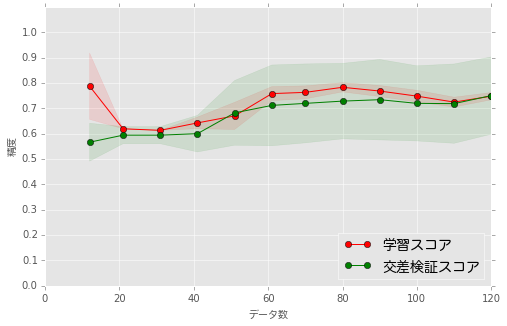

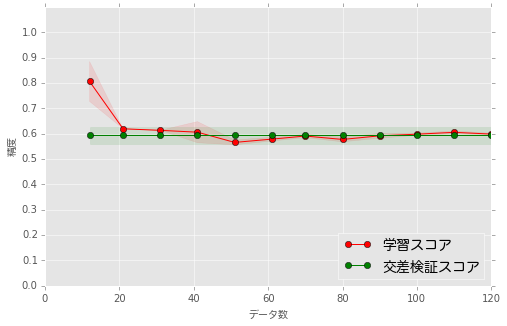

In [9]:
# File Name
RESULT_FILE_NAME = "emolex_all_ht.csv"

# Load data as DF
df = CreateDfForModel(ft_wld=False)

# Create X, y for model
y, X = dmatrices(
    'result ~ \
    anger_home + fear_home + disgust_home + sadness_home + \
    surprise_home + trust_home + joy_home + anticipation_home + \
    anger_away + fear_away + disgust_away + sadness_away + \
    surprise_away + trust_away + joy_away + anticipation_away + \
    pos_home + neg_home + pos_away + neg_away + \
    diff_anger + diff_fear + diff_disgust + diff_sadness + diff_surprise + \
    diff_trust + diff_joy + diff_anticipation + diff_pos + diff_neg',
    df, return_type="dataframe")
y = np.ravel(y)

# Model Training and Results
model_log, model_svc = ModelAccuracy(X, y, penalty='l1', log_variables=True)

# Plot Learning Curve
plot_learning_curve(model_log, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))
plot_learning_curve(model_svc, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))

### WIN LOSE DRAW

--------------------------

[Log]: 	0.542 (cv: 0.529)
[SVC]: 	0.429 (cv: 0.431)


<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


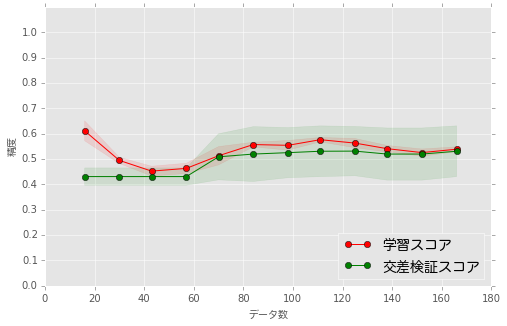

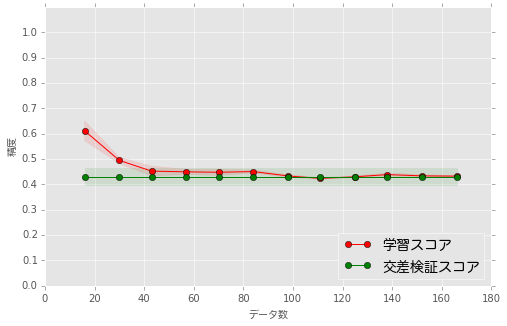

In [10]:
# File Name
RESULT_FILE_NAME = "emolex_all_ht.csv"

# Load data as DF
df = CreateDfForModel(ft_wld=True)

# Create X, y for model
y, X = dmatrices(
    'result ~ \
    anger_home + fear_home + disgust_home + sadness_home + \
    surprise_home + trust_home + joy_home + anticipation_home + \
    anger_away + fear_away + disgust_away + sadness_away + \
    surprise_away + trust_away + joy_away + anticipation_away + \
    pos_home + neg_home + pos_away + neg_away + \
    diff_anger + diff_fear + diff_disgust + diff_sadness + diff_surprise + \
    diff_trust + diff_joy + diff_anticipation + diff_pos + diff_neg',
    df, return_type="dataframe")
y = np.ravel(y)

# Model Training and Results
model_log, model_svc = ModelAccuracy(X, y, penalty='l1', log_variables=False)

# Plot Learning Curve
plot_learning_curve(model_log, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))
plot_learning_curve(model_svc, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))

### Odds

--------------------------

[Log]: 	0.812 (cv: 0.789)
[SVC]: 	0.820 (cv: 0.804)

              var     score
0      Intercept  0.000000
1  score_ht_home  0.000000
2  score_ht_away -0.588509
3   goal_diff_ht  1.471150
4      odds_home -0.164007
5      odds_away  0.160229
6      odds_draw  0.000000


<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


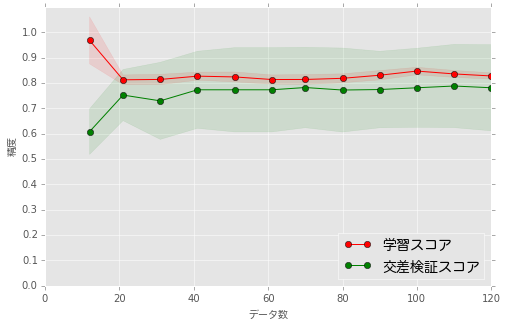

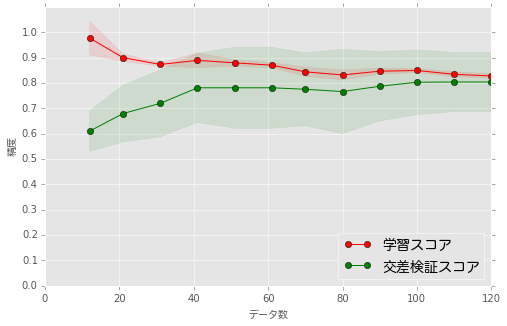

In [11]:
# Read Odds
df = CreateDfForModelOdds(ft_wld=False)

# Create X, y for model
y, X = dmatrices(
    'result ~ score_ht_home + score_ht_away + goal_diff_ht + odds_home + odds_away + odds_draw',
#     'result ~ odds_home + odds_away + odds_draw',
            df, return_type="dataframe")
y = np.ravel(y)

# Model Training and Results
model_log, model_svc = ModelAccuracy(X, y, penalty='l1', log_variables=True)

# Plot Learning Curve
plot_learning_curve(model_log, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))
plot_learning_curve(model_svc, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))

--------------------------

[Log]: 	0.605 (cv: 0.547)
[SVC]: 	0.661 (cv: 0.565)


<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


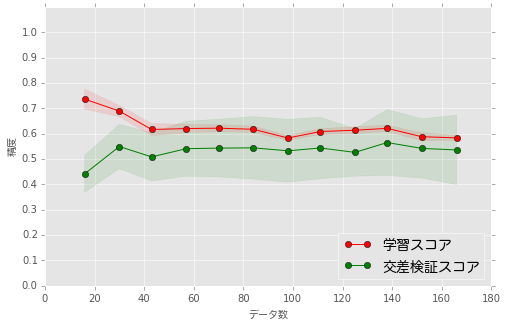

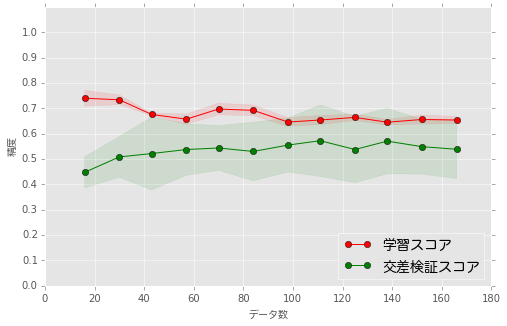

In [12]:
# Read Odds
df = CreateDfForModelOdds(ft_wld=True)

# Create X, y for model
y, X = dmatrices(
    'result ~ score_ht_home + score_ht_away + goal_diff_ht + odds_home + odds_away + odds_draw',
#     'result ~ odds_home + odds_away + odds_draw',
            df, return_type="dataframe")
y = np.ravel(y)

# Model Training and Results
model_log, model_svc = ModelAccuracy(X, y, penalty='l1', log_variables=False)

# Plot Learning Curve
plot_learning_curve(model_log, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))
plot_learning_curve(model_svc, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))

# Emolex and Emoji

--------------------------

[Log]: 	0.727 (cv: 0.719)
[SVC]: 	0.594 (cv: 0.594)

                   var     score
0           Intercept  0.000000
1          anger_home  0.000000
2           fear_home  0.000000
3        disgust_home  0.000000
4        sadness_home  0.000000
5       surprise_home  0.000000
6          trust_home  0.000000
7            joy_home  0.000000
8   anticipation_home  0.000000
9          anger_away  0.000000
10          fear_away  0.000000
11       disgust_away  0.000000
12       sadness_away  0.000000
13      surprise_away  0.000000
14         trust_away  0.000000
15           joy_away  0.000000
16  anticipation_away  0.000000
17           pos_home  0.343855
18           neg_home  0.000000
19           pos_away  0.000000
20           neg_away  0.000000
21         diff_anger  0.000000
22          diff_fear  0.000000
23       diff_disgust  0.000000
24       diff_sadness  0.000000
25      diff_surprise  0.000000
26         diff_trust  0.000000
27           diff_joy 

<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


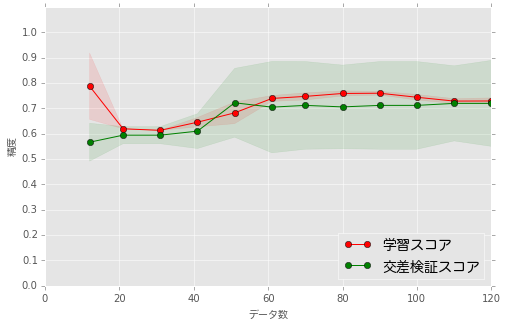

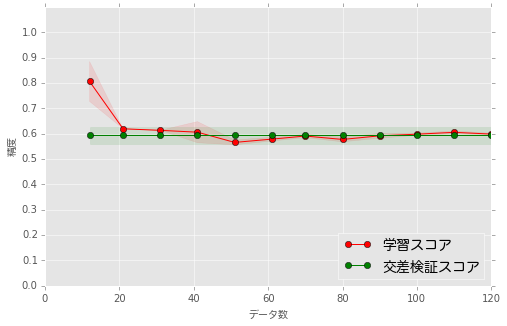

In [14]:
# ============================================
# WIN LOSE

# File Name
RESULT_FILE_NAME = "emolex_emoji_all_ht.csv"

# Load data as DF
df = CreateDfForModel(ft_wld=False)

# Create X, y for model
y, X = dmatrices(
    'result ~ \
    anger_home + fear_home + disgust_home + sadness_home + \
    surprise_home + trust_home + joy_home + anticipation_home + \
    anger_away + fear_away + disgust_away + sadness_away + \
    surprise_away + trust_away + joy_away + anticipation_away + \
    pos_home + neg_home + pos_away + neg_away + \
    diff_anger + diff_fear + diff_disgust + diff_sadness + diff_surprise + \
    diff_trust + diff_joy + diff_anticipation + diff_pos + diff_neg',
    df, return_type="dataframe")
y = np.ravel(y)

# Model Training and Results
model_log, model_svc = ModelAccuracy(X, y, penalty='l1', log_variables=True)

# Plot Learning Curve
plot_learning_curve(model_log, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))
plot_learning_curve(model_svc, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))

--------------------------

[Log]: 	0.531 (cv: 0.519)
[SVC]: 	0.429 (cv: 0.431)


<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


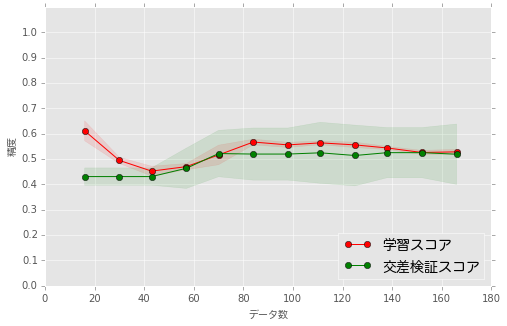

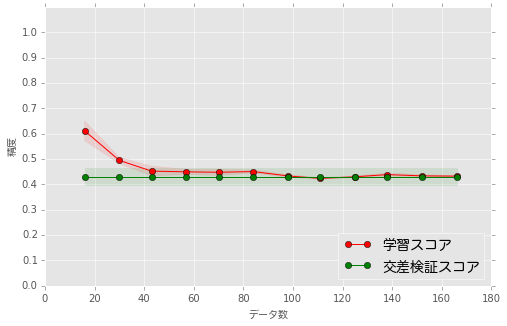

In [15]:
# =============================
# WIN LOSE DRAW

# File Name
RESULT_FILE_NAME = "emolex_emoji_all_ht.csv"

# Load data as DF
df = CreateDfForModel(ft_wld=True)

# Create X, y for model
y, X = dmatrices(
    'result ~ \
    anger_home + fear_home + disgust_home + sadness_home + \
    surprise_home + trust_home + joy_home + anticipation_home + \
    anger_away + fear_away + disgust_away + sadness_away + \
    surprise_away + trust_away + joy_away + anticipation_away + \
    pos_home + neg_home + pos_away + neg_away + \
    diff_anger + diff_fear + diff_disgust + diff_sadness + diff_surprise + \
    diff_trust + diff_joy + diff_anticipation + diff_pos + diff_neg',
    df, return_type="dataframe")
y = np.ravel(y)

# Model Training and Results
model_log, model_svc = ModelAccuracy(X, y, penalty='l1', log_variables=False)

# Plot Learning Curve
plot_learning_curve(model_log, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))
plot_learning_curve(model_svc, "Score HT", X, y, ylim=(0, 1.1), cv=18, train_sizes=np.linspace(.1, 1.0, 12))